# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Sven Borden, Sorya Jullien, Artur Jesslen  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Before running this notebook, verify that you have all requirements by running this command in your terminal:
`pip install numpy opencv-python matplotlib mlxtend scikit-learn scikit-image seaborn`

## Be sure to have `wagner_fisher.py` file in the src directory
It can be find in the moodle assignement or following this [link][gist].

[gist]: https://gist.github.com/kylebgorman/8034009

In [1]:
import wagner_fisher as wf

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import wagner_fisher as wf
import warnings
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
import seaborn as sns

warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Utily function :

In [3]:
# Calculate Prediction matrix from a given distance matrix
def calculate_prediction_matrix(dist_matrix, criterion = np.average):
    pred_matrix = np.zeros((dist_matrix.shape[0], 2))
    nb_element = dist_matrix.shape[1] // 2
    for i in range(dist_matrix.shape[0]):
        zeros = dist_matrix[i, :nb_element]
        ones = dist_matrix[i, nb_element:]
        dist_to_zeros = criterion(zeros[np.nonzero(zeros)])
        dist_to_ones = criterion(ones[np.nonzero(ones)])
        if dist_to_zeros < dist_to_ones:
            pred_matrix[i, 0] = 1
        else:
            pred_matrix[i, 1] = 1
    return pred_matrix == 1

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

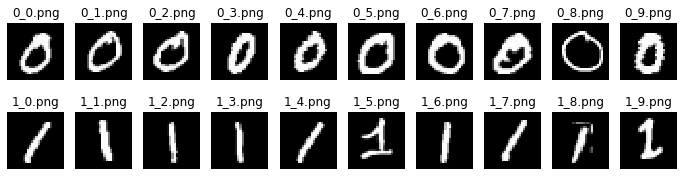

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'

#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])

zeros_im = skimage.io.concatenate_images(ic)
zeros_thresholded_tmp = [cv2.threshold(img.copy(), 2, 1, cv2.THRESH_BINARY) for img in zeros_im]
zeros_thresholded = [threshold for _, threshold in zeros_thresholded_tmp]
del zeros_thresholded_tmp


#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))

ones_im = skimage.io.concatenate_images(ic)
ones_thresholded_tmp = [cv2.threshold(img.copy(), 2, 1, cv2.THRESH_BINARY) for img in ones_im]
ones_thresholded = [threshold for _, threshold in ones_thresholded_tmp]
del ones_thresholded_tmp


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

#### Find descriptors 

In [5]:
MIN_CONTOUR_POINT = 20

In [6]:
def find_contour(img, opencv_version):
    """ Finds and returns the contour of the image"""
    contour = []
    if int(opencv_version) == 3:
        _, contour, _ = cv2.findContours(img, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE)
    else:
        contour, _ = cv2.findContours(img.copy(), mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE)
    
    contour_array = contour[0].reshape(-1, 2)
    if contour_array.shape[0] < MIN_CONTOUR_POINT:
        contour_array = contour[1].reshape(-1, 2)
    return contour_array

def convert_contour(contour):
    contour_complex = np.empty(contour.shape[:-1], dtype=complex)
    contour_complex.real = contour[:, 0]
    contour_complex.imag = contour[:, 1]
    return contour_complex

In [7]:
def find_descriptor(contour):
    """ Finds and returns the Fourier-Descriptor from the image contour"""
    return np.fft.fft(contour)

In [8]:
# Store version of opencv to adapt the method used
opencv_version, opencv_version_minor, _ = cv2.__version__.split(".")
print('OpenCV Version: {}.{}'.format(opencv_version, opencv_version_minor))

OpenCV Version: 4.2


In [9]:
zero_contours = []
one_contours = []

zero_descriptors = []
one_descriptors = []

for zero_img, one_img in zip(zeros_thresholded, ones_thresholded):
    contour0_raw = find_contour(zero_img, opencv_version)
    contour0_complex = convert_contour(contour0_raw)
    descriptor0 = find_descriptor(contour0_complex)
    
    contour1_raw = find_contour(one_img, opencv_version)
    contour1_complex = convert_contour(contour1_raw)
    descriptor1 = find_descriptor(contour1_complex)
    
    # Save for later usage
    zero_contours.append(contour0_raw)
    one_contours.append(contour1_raw)
    zero_descriptors.append(descriptor0)
    one_descriptors.append(descriptor1)


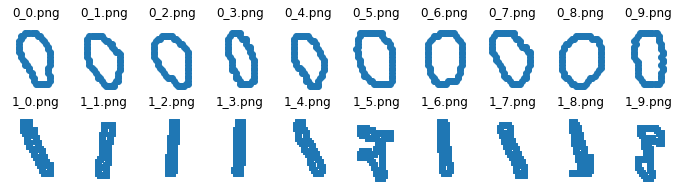

In [10]:
# Plot contours 
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm, cont in zip(axes[0], zeros_im, zeros_names, zero_contours):
    ax.scatter(cont[:, 0], cont[:, 1])
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 28)
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm, cont in zip(axes[1], ones_im, ones_names, one_contours):
    ax.scatter(cont[:, 0], cont[:, 1], marker=',')
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 28)
    ax.axis('off')
    ax.set_title(nm)

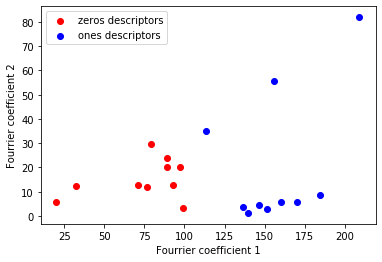

In [11]:
nb_coeff = 2
zeros_coeff = []
ones_coeff = []

for zero_descriptor, one_descriptor in zip(zero_descriptors, one_descriptors):
    zeros_coeff.append(np.absolute(zero_descriptor[1:nb_coeff+1]))
    ones_coeff.append(np.absolute(one_descriptor[1:nb_coeff+1]))

plt.scatter(np.asarray(zeros_coeff)[:,0], np.asarray(zeros_coeff)[:,1], color='red', label='zeros descriptors')
plt.scatter(np.asarray(ones_coeff)[:,0], np.asarray(ones_coeff)[:,1], color='blue', label='ones descriptors')   
plt.xlabel("Fourrier coefficient 1")
plt.ylabel("Fourrier coefficient 2")
plt.legend()
plt.show()

We can see that when we project the 0 and 1 images using the space of the magnitude of the descriptors 1 and 2, we can linearly separate our data!  
Moreover, it is invariant to translation (dependant of descriptor 0) and to rotation (change only phase).

#### Classification
To classify zeros and ones, we will use SVM

In [12]:
# create the training dataset from the two fourrier coefficients
x_train = np.concatenate((zeros_coeff, ones_coeff), axis=0)
y_train = np.concatenate((np.zeros(len(zeros_coeff), dtype=int), np.ones(len(ones_coeff), dtype=int)), axis=0)

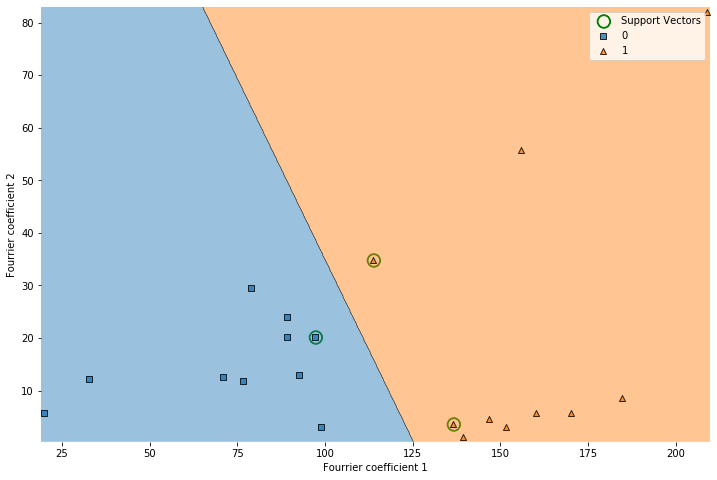

In [13]:
# train
classifier = SVC(kernel='linear')
classifier.fit(x_train, y_train)
supports = classifier.support_vectors_

plt.figure(figsize=(12,8))
plt.scatter(supports[:,0], supports[:,1], marker="$\u25EF$",linewidth='1', s=200, edgecolors='green', label='Support Vectors')
plot_decision_regions(x_train, y_train, clf=classifier, legend=2)
plt.xlabel("Fourrier coefficient 1")
plt.ylabel("Fourrier coefficient 2")
plt.legend()
plt.show()

### Freeman/Chain Code 

In [14]:
nb_direction = 8

In [15]:
def get_code(angle, nb_direction):
    modulo_angle = 360 // nb_direction
    angle_direction = np.linspace(-180, 180, nb_direction+1)
    return np.abs(angle_direction - angle).argmin()

In [16]:
def create_freeman_code(contour, nb_direction):
    """Create freeman code (string containing integer character) and differentia freeman code from given image"""
    code = ""
    diffCode = ""
    # Compute code
    for i in range(contour.shape[0]-1):
        next_dir = contour[i+1] - contour[i]
        # in degrees
        angle = math.atan2(next_dir[1], next_dir[0]) * 180 / math.pi
        code += str(get_code(angle, nb_direction))
    
    # Compute differential code
    for i in range(len(code)-1):
        new_code = str((int(code[i+1]) - int(code[i]) + nb_direction) % nb_direction)
        diffCode += new_code

    return code, diffCode

def calculate_distance(code1, code2):
    return wf.WagnerFischer(code1, code2).cost


In [17]:
zero_freeman_codes = []
one_freeman_codes = []


for contour0, contour1 in zip(zero_contours, one_contours):
    zero_freeman_codes.append(create_freeman_code(contour0, nb_direction))
    one_freeman_codes.append(create_freeman_code(contour1, nb_direction))


#### Display results of distance between freeman codes

In [18]:
def calculate_distance_matrix(freeman_codes, dist):
    nb_data = len(freeman_codes)
    dist_matrix = np.zeros((nb_data, nb_data))
    diff_dist_matrix = np.zeros((nb_data, nb_data))
    for i in range(nb_data):
        for j in range(nb_data):
            dist_matrix[i, j] = dist(freeman_codes[i][0], freeman_codes[j][0])
            diff_dist_matrix[i, j] = dist(freeman_codes[i][1], freeman_codes[j][1])
            
    return dist_matrix, diff_dist_matrix


In [19]:
freeman_dist_matrix, freeman_diff_dist_matrix = calculate_distance_matrix(zero_freeman_codes + one_freeman_codes, dist = calculate_distance)


In [20]:
freeman_pred_matrix = calculate_prediction_matrix(freeman_dist_matrix, np.min)
freeman_diff_pred_matrix = calculate_prediction_matrix(freeman_diff_dist_matrix, np.min)

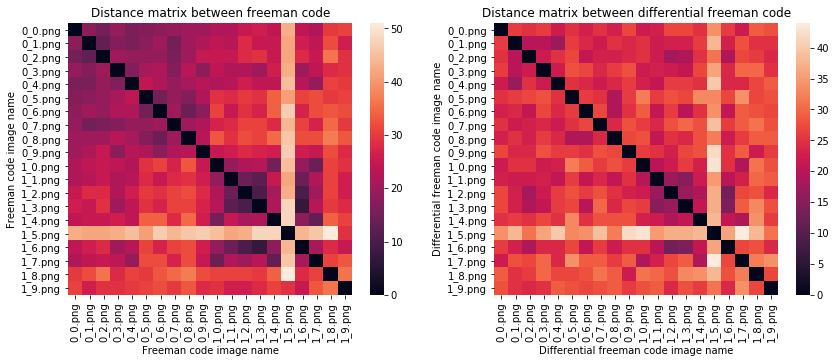

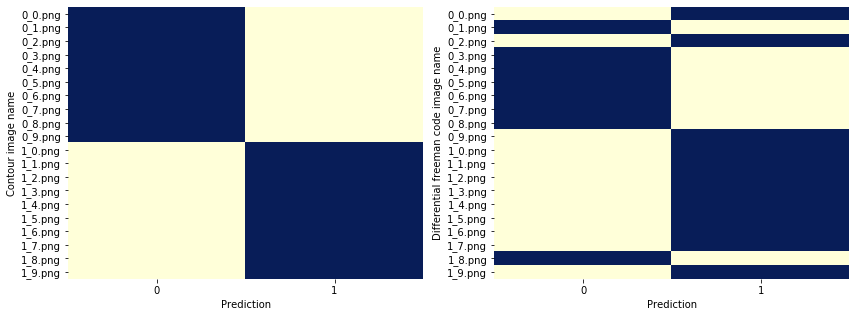

In [21]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title('Distance matrix between freeman code')
sns.heatmap(freeman_dist_matrix, xticklabels = zeros_names + ones_names, yticklabels = zeros_names + ones_names)
plt.xlabel('Freeman code image name')
plt.ylabel('Freeman code image name')

plt.subplot(122)
plt.title('Distance matrix between differential freeman code')
sns.heatmap(freeman_diff_dist_matrix, xticklabels = zeros_names + ones_names, yticklabels = zeros_names + ones_names)
plt.xlabel('Differential freeman code image name')
plt.ylabel('Differential freeman code image name')

plt.figure(figsize=(14,5))
plt.subplot(121)
sns.heatmap(freeman_pred_matrix, yticklabels = zeros_names + ones_names, xticklabels = ['0', '1'], cbar=False, cmap="YlGnBu")
plt.xlabel('Prediction')
plt.ylabel('Contour image name')

plt.subplot(122)
sns.heatmap(freeman_diff_pred_matrix, yticklabels = zeros_names + ones_names, xticklabels = ['0', '1'], cbar=False, cmap="YlGnBu")
plt.xlabel('Prediction')
plt.ylabel('Differential freeman code image name')
plt.show()

As we can see, the prediction is pretty accurate using the freeman code (but results are sensitive to the parameters - number of direction, prediction criterion (i.e. average, min, ...))  
For the differential freeman code, the results are not as good. This may be due to the dataset (low resolution, ...). This is a basic implementation. Results could be improved. Differerential code is used to improve the invariance to rotation.

### Distance map

In [22]:
def create_distance_map(img, contour):
    """Create distance map from binary image"""
    if len(np.shape(contour)) > 2:
        raise NameError('One image contour expected only.')    
    
    # Initialization 
    out = np.full(img.shape, np.inf)
    for i in range(len (contour)):
        out[contour[i][0]][contour[i][1]] = 0 #contours = 0
    
    # Direct passage
    for i in range(1, out.shape[0]-1):
        for j in range(1, out.shape[1]-1):
            out[i, j] = np.array([out[i-1, j-1] + 7, out[i-1, j] + 5, out[i-1, j+1] + 7, out[i, j-1] + 5, out[i, j]]).min()
    
    # Inverse passage 
    for i in range(out.shape[0]-2, 0, -1):
        for j in range(out.shape[1]-2, 0, -1):
            out[i, j] = np.array([out[i, j+1] + 5, out[i+1, j-1] + 7, out[i+1, j] + 5, out[i+1, j+1] + 7, out[i, j]]).min()  
    return out

In [23]:
def compute_dist(contour, dist_map):
    """Compute distance between a binary image and another image using its distance map"""
    if len(np.shape(contour)) > 2:
        raise NameError('One image contour expected only.')
        
    dist = 0
    for i in range(contour.shape[0]):
        dist += dist_map[contour[i][0],contour[i][1]] 
    
    return dist/contour.shape[0]

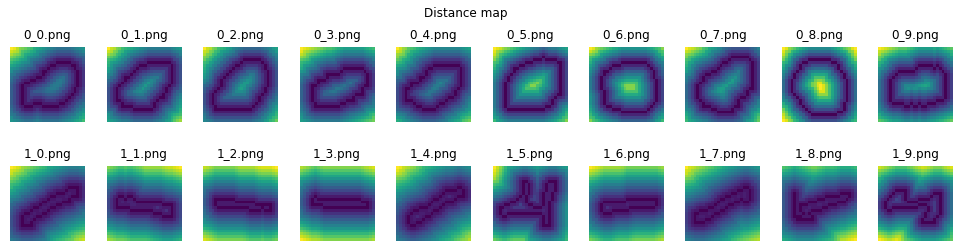

In [24]:
zeros_distance_map = [create_distance_map(img, contour) for img, contour in zip(zeros_thresholded, zero_contours)]
ones_distance_map = [create_distance_map(img, contour) for img, contour in zip(ones_thresholded, one_contours)]

fig, axes = plt.subplots(2, len(zeros_distance_map), figsize=(17, 4))
fig.suptitle("Distance map")
for ax, im, nm in zip(axes[0], zeros_distance_map, zeros_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_distance_map, ones_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)


#### Calculating distance for each zero/one image and associating to its nearest class before rotation/translation

Calculating distance for each zero image and associating to its nearest class (min distance):
Image 0_1.png: Contour closer to image of type 0
Image 0_2.png: Contour closer to image of type 0
Image 0_3.png: Contour closer to image of type 0
Image 0_4.png: Contour closer to image of type 0
Image 0_5.png: Contour closer to image of type 0
Image 0_6.png: Contour closer to image of type 0
Image 0_7.png: Contour closer to image of type 0
Image 0_8.png: Contour closer to image of type 0
Image 0_9.png: Contour closer to image of type 0

Calculating distance for each one image and associating to its nearest class (min distance):
Image 1_1.png: Contour closer to image of type 1
Image 1_2.png: Contour closer to image of type 1
Image 1_3.png: Contour closer to image of type 1
Image 1_4.png: Contour closer to image of type 1
Image 1_5.png: Contour closer to image of type 0
Image 1_6.png: Contour closer to image of type 1
Image 1_7.png: Contour closer to image of type 1
Image 1_8.png: Contour close

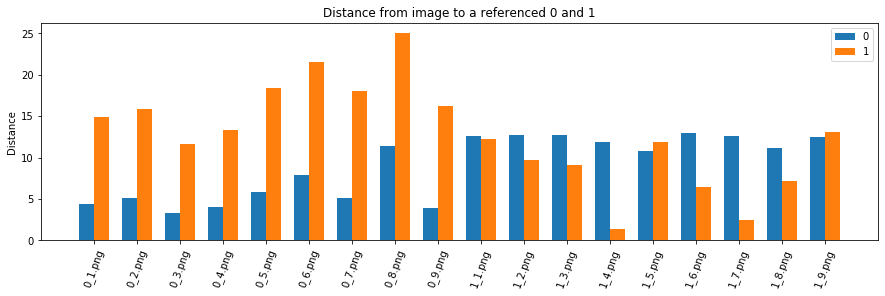

In [25]:
zero_dist_map = zeros_distance_map[0]
one_dist_map = ones_distance_map[0]

zeros_dist = []
ones_dist = []
print("Calculating distance for each zero image and associating to its nearest class (min distance):")
for i in range(1, len(zeros_distance_map)):
    dist_to_zero = compute_dist(zero_contours[i], zero_dist_map)
    dist_to_one = compute_dist(zero_contours[i], one_dist_map)
    zeros_dist.append(dist_to_zero)
    zeros_dist.append(dist_to_one)
    print('Image {}: Contour closer to image of type {}'.format(zeros_names[i], 0 if dist_to_zero < dist_to_one else 1))

print("\nCalculating distance for each one image and associating to its nearest class (min distance):")
for i in range(1, len(zeros_distance_map)):
    dist_to_zero = compute_dist(one_contours[i], zero_dist_map)
    dist_to_one = compute_dist(one_contours[i], one_dist_map)
    ones_dist.append(dist_to_zero)
    ones_dist.append(dist_to_one)
    print('Image {}: Contour closer to image of type {}'.format(ones_names[i], 0 if dist_to_zero < dist_to_one else 1))


names = zeros_names[1:] + ones_names[1:]
x = np.arange(len(names))

# Area and diameter comparaison chart
data1 = zeros_dist[::2] + ones_dist[::2]
data2 = zeros_dist[1::2] + ones_dist[1::2]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,4))
rects1 = ax.bar(x - width/2, data1, width, label='0')
rects2 = ax.bar(x + width/2, data2, width, label='1')

ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
ax.set_ylabel('Distance')
for tick in ax.get_xticklabels():
    tick.set_rotation(70)

plt.title('Distance from image to a referenced 0 and 1')
plt.show()



In [26]:
def calculate_distance_matrix(contours, dist_map, dist):
    nb_data1 = len(contours)
    nb_data2 = len(dist_map)
    dist_matrix = np.zeros((nb_data1, nb_data2))
    for i in range(nb_data1):
        for j in range(nb_data2):
            dist_matrix[i, j] = dist(contours[i], dist_map[j])
            
    return dist_matrix

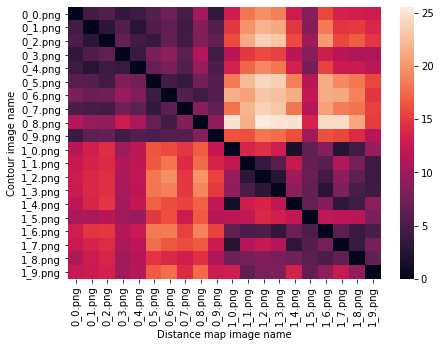

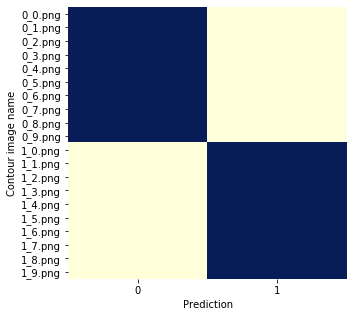

In [27]:
distance_matrix = calculate_distance_matrix(zero_contours + one_contours, zeros_distance_map + ones_distance_map, compute_dist)
prediction_matrix = calculate_prediction_matrix(distance_matrix)

plt.figure(figsize=(7,5))
sns.heatmap(distance_matrix, xticklabels = zeros_names + ones_names, yticklabels = zeros_names + ones_names)
plt.xlabel('Distance map image name')
plt.ylabel('Contour image name')
plt.figure(figsize=(5,5))
sns.heatmap(prediction_matrix, yticklabels = zeros_names + ones_names, xticklabels = ['0', '1'], cbar=False, cmap="YlGnBu")
plt.xlabel('Prediction')
plt.ylabel('Contour image name')
plt.show()

In the previous plots, we can see that the distance is higher for image of different type.  
The second plot show the prediction by averaging the distance over the class. We can see that all the prediction are accurate (when taking the average) and the predicted class correspond always to the real class

#### Using translation and rotation to find closest class

In [28]:
# Translation of image
def contour_translation(contour, trans_x, trans_y):
    translation_vect = [[trans_x],[trans_y]]
    translation_mat = np.repeat(translation_vect, len(contour), axis=1)
    translation_mat = translation_mat.transpose()
    
    #addition
    translated_contours = np.add(contour, translation_mat)
    
    #check if in bounds
    up_limit = 28
    idx = np.where(translated_contours >= up_limit)
    translated_contours = np.delete(translated_contours, idx[0], axis=0)
    low_limit = 0
    idx = np.where(translated_contours < low_limit)
    translated_contours = np.delete(translated_contours, idx[0], axis=0)
    
    return translated_contours

In [29]:
# Rotation of image
def contour_rotation(contour, angle, center):

    angle = angle * np.pi / 180 # degrees to radians
    rotated_contours = np.zeros(contour.shape, dtype = np.uint)
    ox, oy = center
    for i in range(contour.shape[0]):       
        px, py = contour[i, :]
        #+0.5 is to take the closest integer when approximating
        rotated_contours[i,0] = int(ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy) + 0.5)
        rotated_contours[i,1] = int(oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy) + 0.5)

    #check if in bounds
    up_limit = 28
    idx = np.where(rotated_contours >= up_limit)
    rotated_contours = np.delete(rotated_contours, idx[0], axis=0)
    low_limit = 0
    idx = np.where(rotated_contours < low_limit)
    rotated_contours = np.delete(rotated_contours, idx[0], axis=0)
  
    return rotated_contours

Image 1: minimum distance = 3.00 for a translation of (0, 1) and an angle = 0.00°.
Image 2: minimum distance = 3.48 for a translation of (-1, 1) and an angle = 345.00°.
Image 3: minimum distance = 3.38 for a translation of (0, 0) and an angle = 0.00°.
Image 4: minimum distance = 2.63 for a translation of (0, 1) and an angle = 0.00°.
Image 5: minimum distance = 5.82 for a translation of (0, 0) and an angle = 0.00°.
Image 6: minimum distance = 7.48 for a translation of (-1, -1) and an angle = 225.00°.
Image 7: minimum distance = 4.95 for a translation of (1, 0) and an angle = 0.00°.
Image 8: minimum distance = 7.48 for a translation of (0, 0) and an angle = 90.00°.
Image 9: minimum distance = 3.53 for a translation of (0, 0) and an angle = 15.00°.


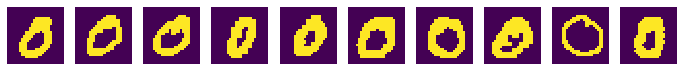

In [30]:
distance_btw_zero_t_r = []
distance_from_zero_to_one_t_r = []
zeros_im_t_r = zeros_thresholded# ones_thresholded):
# optimal translation for the zero images
fig, ax = plt.subplots(1, len(zeros_distance_map), figsize=(12, 3))
ax[0].imshow(zeros_thresholded[0])
ax[0].axis('off')
scale = 1
for i in range(1, len(zeros_distance_map)):
    height, width = zeros_thresholded[i].shape
    dist_final = np.inf
    x_final = 0
    y_final = 0
    angle_final = 0
    dist_final2 = np.inf
    x_final2 = 0
    y_final2 = 0
    angle_final2 = 0
    center = (width // 2, height // 2)
    
    for trans_x in range(-4,5,1):        
        for trans_y in range(-4,5,1):
            cnt_translation = contour_translation(zero_contours[i], trans_x, trans_y)
            for angle in np.arange(0, 360, 15):
                cnt_rotation = contour_rotation(cnt_translation, angle, center)
                dist = compute_dist(cnt_rotation, zero_dist_map)
                if dist < dist_final:
                    dist_final = dist
                    x_final = trans_x
                    y_final = trans_y
                    angle_final = angle
                dist2 = compute_dist(cnt_rotation, one_dist_map)
                if dist2 < dist_final2:
                    dist_final2 = dist2
                    x_final2 = trans_x
                    y_final2 = trans_y
                    angle_final2 = angle
    
    distance_btw_zero_t_r.append(dist_final)
    distance_from_zero_to_one_t_r.append(dist_final2)
    translation_matrix = np.float32([[1, 0, x_final], [0, 1, y_final]])
    rotation_matrix = cv2.getRotationMatrix2D(center, -angle_final, scale)
    img_translation = cv2.warpAffine(zeros_thresholded[i], translation_matrix, (width, height))
    img_translated_rotated = cv2.warpAffine(img_translation, rotation_matrix, (width, height))
    print('Image {}: minimum distance = {:.02f} for a translation of ({}, {}) and an angle = {:.02f}°.'.format(i, dist_final, x_final, y_final, angle_final))
    ax[i].axis('off')
    ax[i].imshow(zeros_im_t_r[i])
    zeros_im_t_r[i] = img_translated_rotated
    

Image 1: minimum distance = 2.91 for a translation of (0, 2) and an angle = 225.00°.
Image 2: minimum distance = 2.90 for a translation of (-1, -2) and an angle = 45.00°.
Image 3: minimum distance = 2.90 for a translation of (1, 1) and an angle = 30.00°.
Image 4: minimum distance = 1.43 for a translation of (0, 0) and an angle = 0.00°.
Image 5: minimum distance = 10.12 for a translation of (1, 1) and an angle = 15.00°.
Image 6: minimum distance = 2.79 for a translation of (0, -2) and an angle = 30.00°.
Image 7: minimum distance = 1.82 for a translation of (0, 1) and an angle = 0.00°.
Image 8: minimum distance = 4.18 for a translation of (1, -1) and an angle = 15.00°.
Image 9: minimum distance = 6.67 for a translation of (0, 2) and an angle = 225.00°.


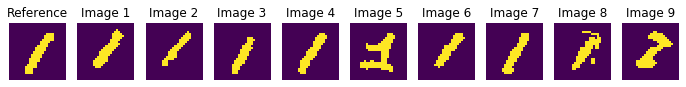

In [31]:
distance_btw_one_t_r = []
distance_from_one_to_zero_t_r = []
ones_im_t_r = ones_thresholded
# optimal translation for the ones images
fig, ax = plt.subplots(1, len(ones_distance_map), figsize=(12, 3))
ax[0].imshow(ones_thresholded[0])
ax[0].axis('off')
ax[0].set_title('Reference')

for i in range(1, len(ones_distance_map)):
    height, width = ones_thresholded[i].shape
    dist_final = np.inf
    x_final = 0
    y_final = 0
    angle_final = 0
    dist_final2 = np.inf
    x_final2 = 0
    y_final2 = 0
    angle_final2 = 0
    center = (width // 2, height // 2)
    
    for trans_x in range(-4,5,1):
        for trans_y in range(-4,5,1):
            
            cnt_translation = contour_translation(one_contours[i], trans_x, trans_y)
            
            for angle in np.arange(0, 360, 15):
                cnt_rotation = contour_rotation(cnt_translation, angle, center)
                dist = compute_dist(cnt_rotation, zero_dist_map)
                if dist < dist_final:
                    dist_final = dist
                    x_final = trans_x
                    y_final = trans_y
                    angle_final = angle
                dist2 = compute_dist(cnt_rotation, one_dist_map)
                if dist2 < dist_final2:
                    dist_final2 = dist2
                    x_final2 = trans_x
                    y_final2 = trans_y
                    angle_final2 = angle
    distance_from_one_to_zero_t_r.append(dist_final)
    distance_btw_one_t_r.append(dist_final2)
    translation_matrix = np.float32([[1, 0, x_final2], [0, 1, y_final2]])
    rotation_matrix = cv2.getRotationMatrix2D(center, -angle_final2, scale)
    img_translation = cv2.warpAffine(ones_thresholded[i], translation_matrix, (width, height))
    img_translated_rotated = cv2.warpAffine(img_translation, rotation_matrix, (width, height))
    print('Image {}: minimum distance = {:.02f} for a translation of ({}, {}) and an angle = {:.02f}°.'.format(i, dist_final2, x_final2, y_final2, angle_final2))
    ax[i].axis('off')
    ax[i].set_title("Image {}".format(i))
    ax[i].imshow(img_translated_rotated)
    ones_im_t_r[i] = img_translated_rotated
    

#### Comparaison of results with translation/rotation and without it

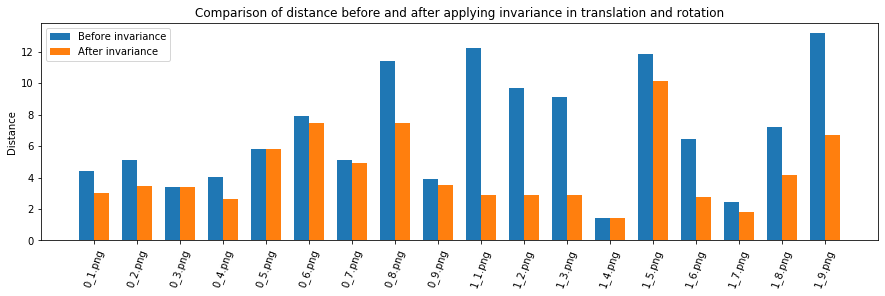

In [32]:
names = zeros_names[1:] + ones_names[1:]
x = np.arange(len(names))

# Area and diameter comparaison chart
data1 = zeros_dist[::2] + ones_dist[1::2]
data2 = distance_btw_zero_t_r + distance_btw_one_t_r

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,4))
rects1 = ax.bar(x - width/2, data1, width, label='Before invariance')
rects2 = ax.bar(x + width/2, data2, width, label='After invariance')

ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylabel('Distance')
ax.legend()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)

plt.title('Comparison of distance before and after applying invariance in translation and rotation')
plt.show()


We can see that after finding the optimal translation/rotation, the distance is always equal or smaller

Image 0_1.png: Contour closer to image of type 0
Image 0_2.png: Contour closer to image of type 0
Image 0_3.png: Contour closer to image of type 0
Image 0_4.png: Contour closer to image of type 0
Image 0_5.png: Contour closer to image of type 0
Image 0_6.png: Contour closer to image of type 0
Image 0_7.png: Contour closer to image of type 0
Image 0_8.png: Contour closer to image of type 0
Image 0_9.png: Contour closer to image of type 0
Image 1_1.png: Contour closer to image of type 1
Image 1_2.png: Contour closer to image of type 1
Image 1_3.png: Contour closer to image of type 1
Image 1_4.png: Contour closer to image of type 1
Image 1_5.png: Contour closer to image of type 0
Image 1_6.png: Contour closer to image of type 1
Image 1_7.png: Contour closer to image of type 1
Image 1_8.png: Contour closer to image of type 1
Image 1_9.png: Contour closer to image of type 1


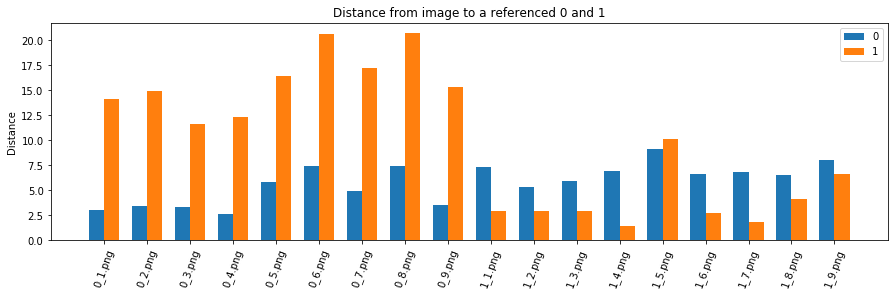

In [33]:
for name, zero_to_zero, zero_to_one in zip(zeros_names[1:], distance_btw_zero_t_r, distance_from_zero_to_one_t_r):
    print('Image {}: Contour closer to image of type {}'.format(name, 0 if zero_to_zero < zero_to_one else 1))
for name, one_to_one, one_to_zero in zip(ones_names[1:], distance_btw_one_t_r, distance_from_one_to_zero_t_r):
    print('Image {}: Contour closer to image of type {}'.format(name, 0 if one_to_zero < one_to_one else 1))


names = zeros_names[1:] + ones_names[1:]
x = np.arange(len(names))

# Area and diameter comparaison chart
data1 = distance_btw_zero_t_r + distance_from_one_to_zero_t_r
data2 = distance_from_zero_to_one_t_r + distance_btw_one_t_r

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,4))
rects1 = ax.bar(x - width/2, data1, width, label='0')
rects2 = ax.bar(x + width/2, data2, width, label='1')

ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylabel('Distance')
ax.legend()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)

plt.title('Distance from image to a referenced 0 and 1')
plt.show()


From the previous plot, we can see that the results are slightly better now that it is invariant to translation and rotation (only one data that is misclassified vs. 2 before)

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

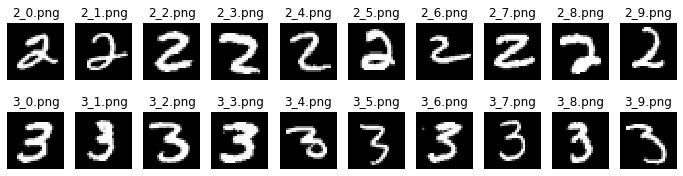

In [34]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])

twos_im = skimage.io.concatenate_images(ic)
twos_thresholded_tmp = [cv2.threshold(img.copy(), 2, 1, cv2.THRESH_BINARY) for img in twos_im]
twos_thresholded = [threshold for _, threshold in twos_thresholded_tmp]
del twos_thresholded_tmp

#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))

threes_im = skimage.io.concatenate_images(ic)
threes_thresholded_tmp = [cv2.threshold(img.copy(), 2, 1, cv2.THRESH_BINARY) for img in threes_im]
threes_thresholded = [threshold for _, threshold in threes_thresholded_tmp]
del threes_thresholded_tmp

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [35]:
zero_contours = []
one_contours = []
two_contours = []
three_contours = []

zero_descriptors = []
one_descriptors = []
two_descriptors = []
three_descriptors = []

for zero_img, one_img, two_img, three_img in zip(zeros_im, ones_im, twos_im, threes_im):
    contour0_raw = find_contour(zero_img, opencv_version)
    contour0_complex = convert_contour(contour0_raw)
    descriptor0 = find_descriptor(contour0_complex)
    
    contour1_raw = find_contour(one_img, opencv_version)
    contour1_complex = convert_contour(contour1_raw)
    descriptor1 = find_descriptor(contour1_complex)
    
    contour2_raw = find_contour(two_img, opencv_version)
    contour2_complex = convert_contour(contour2_raw)
    descriptor2 = find_descriptor(contour2_complex)
    
    contour3_raw = find_contour(three_img, opencv_version)
    contour3_complex = convert_contour(contour3_raw)
    descriptor3 = find_descriptor(contour3_complex)
    
    # Save for later usage
    zero_contours.append(contour0_raw)
    one_contours.append(contour1_raw)
    two_contours.append(contour2_raw)
    three_contours.append(contour3_raw)
    zero_descriptors.append(descriptor0)
    one_descriptors.append(descriptor1)
    two_descriptors.append(descriptor2)
    three_descriptors.append(descriptor3)
    

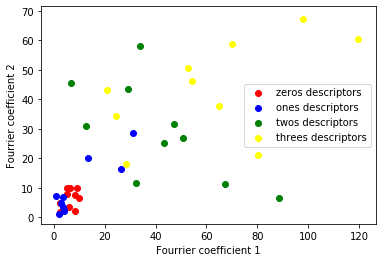

In [36]:
nb_coeff = 2
zeros_coeff = []
ones_coeff = []
twos_coeff = []
threes_coeff = []

MIN_COEFF = 4
MAX_COEFF = nb_coeff+MIN_COEFF

for zero_descriptor, one_descriptor, two_descriptor, three_descriptor \
    in zip(zero_descriptors, one_descriptors, two_descriptors, three_descriptors):
    zeros_coeff.append(np.absolute(zero_descriptor[MIN_COEFF : MAX_COEFF]))
    ones_coeff.append(np.absolute(one_descriptor[MIN_COEFF : MAX_COEFF]))
    twos_coeff.append(np.absolute(two_descriptor[MIN_COEFF : MAX_COEFF]))
    threes_coeff.append(np.absolute(three_descriptor[MIN_COEFF : MAX_COEFF]))

plt.scatter(np.asarray(zeros_coeff)[:,0], np.asarray(zeros_coeff)[:,1], color='red', label='zeros descriptors')
plt.scatter(np.asarray(ones_coeff)[:,0], np.asarray(ones_coeff)[:,1], color='blue', label='ones descriptors') 
plt.scatter(np.asarray(twos_coeff)[:,0], np.asarray(twos_coeff)[:,1], color='green', label='twos descriptors')
plt.scatter(np.asarray(threes_coeff)[:,0], np.asarray(threes_coeff)[:,1], color='yellow', label='threes descriptors') 
plt.xlabel("Fourrier coefficient 1")
plt.ylabel("Fourrier coefficient 2")
plt.legend()
plt.show()

**As we can see in the previous plot, it is not possible to separate linearly the 4 categories**  
In the following section we will try to see if it possible to separate our data using SVM with a kernel and then we will try to separate them by adding a new dimension (i.e. using 3 fourier descriptors instead of 2)

#### SVC multiclass


In [37]:
# create the training dataset from the two fourrier coefficients
x_train = np.concatenate((zeros_coeff, ones_coeff, twos_coeff, threes_coeff), axis=0)
y_train = np.concatenate((np.zeros(len(zeros_coeff), dtype=int), np.ones(len(ones_coeff), dtype=int),np.ones(len(zeros_coeff), dtype=int)*2,np.ones(len(zeros_coeff),dtype=int)*3), axis=0)

In [38]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

model = GridSearchCV(SVC(), params_grid, cv=5)
model.fit(x_train, y_train)
print('Best score for training data: {}'.format(model.best_score_))
print('Best C: {}'.format(model.best_estimator_.C))
print('Best Kernel: {}'.format(model.best_estimator_.kernel))
print('Best Gamma: {}'.format(model.best_estimator_.gamma))
final_model = model.best_estimator_
print("Training set score for SVM: %f" % final_model.score(x_train , y_train))


Best score for training data: 0.65
Best C: 1000
Best Kernel: rbf
Best Gamma: 0.001
Training set score for SVM: 0.950000


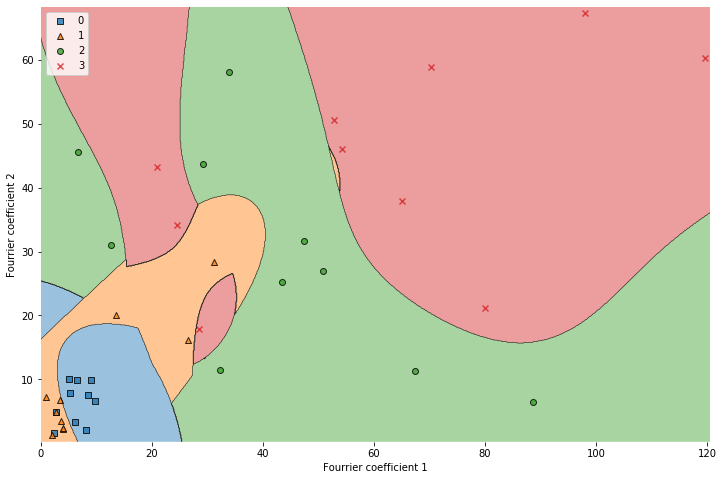

In [39]:
plt.figure(figsize=(12,8))
plot_decision_regions(x_train, y_train, clf=final_model, legend=2)
plt.xlabel("Fourrier coefficient 1")
plt.ylabel("Fourrier coefficient 2")
plt.legend()
plt.show()


Which Descriptor is used have been determined experimentally by looking how well the data then fitted in the region. We obtained 95% fit with the descriptors indexes 4 and 5.

##### SVC classification improvement
If we want to improve the classification, we need to use 3 descriptors. We can see the result below

In [40]:
nb_coeff = 3

for i in range(6):
    MIN_COEFF = i
    MAX_COEFF = nb_coeff+MIN_COEFF
    zeros_coeff = []
    ones_coeff = []
    twos_coeff = []
    threes_coeff = []
    for zero_descriptor, one_descriptor, two_descriptor, three_descriptor \
        in zip(zero_descriptors, one_descriptors, two_descriptors, three_descriptors):
        zeros_coeff.append(np.absolute(zero_descriptor[MIN_COEFF : MAX_COEFF]))
        ones_coeff.append(np.absolute(one_descriptor[MIN_COEFF : MAX_COEFF]))
        twos_coeff.append(np.absolute(two_descriptor[MIN_COEFF : MAX_COEFF]))
        threes_coeff.append(np.absolute(three_descriptor[MIN_COEFF : MAX_COEFF]))

    # create the training dataset from the two fourrier coefficients
    x_train = np.concatenate((zeros_coeff, ones_coeff, twos_coeff, threes_coeff), axis=0)
    y_train = np.concatenate((np.zeros(len(zeros_coeff), dtype=int), np.ones(len(ones_coeff), dtype=int),np.ones(len(zeros_coeff), dtype=int)*2,np.ones(len(zeros_coeff),dtype=int)*3), axis=0)

    # Create the parameter grid based on the results of random search 
    params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    model = GridSearchCV(SVC(), params_grid, cv=5)
    model.fit(x_train, y_train)
    final_model = model.best_estimator_
    print("Training set score for SVM with descriptors range {:d}-{:d} : {:2f}%".format(MIN_COEFF+1, MAX_COEFF, final_model.score(x_train , y_train)*100))



Training set score for SVM with descriptors range 1-3 : 100.000000%
Training set score for SVM with descriptors range 2-4 : 92.500000%
Training set score for SVM with descriptors range 3-5 : 97.500000%
Training set score for SVM with descriptors range 4-6 : 97.500000%
Training set score for SVM with descriptors range 5-7 : 97.500000%
Training set score for SVM with descriptors range 6-8 : 60.000000%


From the previous results, we can see that with the descriptors 1, 2 and 3 the classification results in a 100% accuracy  
Another thing demonstrated by these results is that the first descriptors are the most representative of the image